In [1]:
import random
from collections import namedtuple
from itertools import chain

import cv2
import matplotlib.pyplot as plt
import numpy as np

In [2]:
SiftFeature = namedtuple('SiftFeature', 'keypoints desc')

In [3]:
def sift_detect(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    sift = cv2.SIFT_create(0, 7)
    kp, descriptor = sift.detectAndCompute(gray, None)
    return SiftFeature(kp, descriptor)


def sift_matching(left_desc, right_desc, threshold=0.7):
    matches = []
    for q, desc in enumerate(left_desc):
        distance = np.linalg.norm(desc - right_desc, axis=-1)
        sorted_idx = np.argsort(distance)
        t0, t1 = sorted_idx[0:2]
        if distance[t0] / distance[t1] < threshold:
            matches.append([cv2.DMatch(q, t0, distance[t0])])

    return matches


def points_from_matches(matches, left_feat: SiftFeature, right_feat: SiftFeature):
    return [[left_feat.keypoints[m.queryIdx].pt, right_feat.keypoints[m.trainIdx].pt]
            for m in matches]


def relation_matrix(pt1, pt2):
    x1, y1 = pt1
    x2, y2 = pt2
    return np.array(
        [[x1, y1, 1, 0, 0, 0, -x2 * x1, -x2 * y1, -x2],
         [0, 0, 0, x1, y1, 1, -y2 * x1, -y2 * y1, -y2]]
    )


def solve_homography(pts1, pts2):
    a_matrix = np.vstack([relation_matrix(p, q) for p, q in zip(pts1, pts2)])
    _, _, vt = np.linalg.svd(a_matrix)
    x = vt[-1].reshape((3, 3))
    return x


def ransac_matching(points, rounds=1000, agree_threshold=10):
    max_agrees = -1
    best_agree_idx = None
    best_H = None
    for _ in range(rounds):
        rand_quad = random_select_quad(points)
        H = solve_homography(*rand_quad)

        left_pts, right_pts = separate_left_right_points(points)
        warpped_left_pts = warp_by(left_pts, H)

        distance = np.linalg.norm(warpped_left_pts - right_pts, axis=1)
        agrees = distance < agree_threshold
        if agrees.sum() > max_agrees:
            max_agrees = agrees.sum()
            best_agree_idx = agrees
            best_H = H

    return best_agree_idx, best_H


def random_select_quad(coords):
    rand_coords = random.choices(coords, k=4)
    rand_coords = list(zip(*rand_coords))
    return rand_coords


def warp_by(pts, H):
    warpped = (H @ pts[..., np.newaxis]).reshape((-1, 3))
    warpped /= warpped[:, 2:]
    return warpped


def separate_left_right_points(points):
    points = np.array(list(zip(*points)))
    book_pts, image_pts = np.concatenate([points, np.ones_like(points)[..., :1]], axis=-1)
    return book_pts, image_pts


def pick_agreed_keypoints(feat, matches, idx_name, agreements):
    matched_kps = [feat.keypoints[getattr(m, idx_name)] for m in matches]
    agreed_kps = [mkp for (agree, mkp) in zip(agreements, matched_kps) if agree]
    return agreed_kps


def deviation_vectors(left_pts, right_pts, H, right_image):
    warpped_left = warp_by(left_pts, H).astype(np.uint8)
    right_pts = right_pts.astype(np.uint8)
    for left, right in zip(warpped_left, right_pts):
        # print(left[1::-1], right[1::-1])
        right_image = cv2.arrowedLine(right_image, left[1::-1], right[1::-1], (0, 0, 255))
    return right_image


In [4]:
books = [cv2.imread('1-book1.jpg'), cv2.imread('1-book2.jpg'), cv2.imread('1-book3.jpg')]
image = cv2.imread('1-image.jpg')

In [5]:
image_feat = sift_detect(image)
len(image_feat.keypoints)

1974

In [6]:
books_feat = [sift_detect(book) for book in books]

In [7]:
book = books[0]
book_feat = sift_detect(book)
matches_idx = sift_matching(book_feat.desc, image_feat.desc, 0.8)

flattened_matches = list(chain.from_iterable(matches_idx))
pts = points_from_matches(flattened_matches, book_feat, image_feat)

best_agrees, H = ransac_matching(pts, agree_threshold=3)

matches_idx = [[cv2.DMatch(i, i, 0)] for i in range(best_agrees.sum())]
matched_book_kp = pick_agreed_keypoints(book_feat, flattened_matches, 'queryIdx', best_agrees)
matched_image_kp = pick_agreed_keypoints(image_feat, flattened_matches, 'trainIdx', best_agrees)

In [9]:
pts

[[(18.404264450073242, 52.171295166015625),
  (38.45975112915039, 356.9483642578125)],
 [(18.404264450073242, 52.171295166015625),
  (38.45975112915039, 356.9483642578125)],
 [(18.819307327270508, 311.7950439453125),
  (38.45975112915039, 356.9483642578125)],
 [(21.05607032775879, 269.92144775390625),
  (38.45975112915039, 356.9483642578125)],
 [(21.05607032775879, 269.92144775390625),
  (38.45975112915039, 356.9483642578125)],
 [(40.61625671386719, 160.95578002929688),
  (124.07384490966797, 411.0974426269531)],
 [(43.32037353515625, 78.5180892944336),
  (141.60813903808594, 266.60015869140625)],
 [(48.13285827636719, 121.09601593017578),
  (126.60868072509766, 285.4569091796875)],
 [(50.113216400146484, 85.7945785522461),
  (141.60670471191406, 271.478271484375)],
 [(50.113216400146484, 85.7945785522461),
  (141.60670471191406, 271.478271484375)],
 [(50.2026481628418, 95.84262084960938),
  (137.60061645507812, 275.5401306152344)],
 [(59.47959518432617, 143.013427734375),
  (124.07384

In [13]:
book_pts, image_pts = separate_left_right_points(pts)
image_pts[best_agrees]

array([[ 38.45975113, 356.94836426,   1.        ],
       [141.60813904, 266.60015869,   1.        ],
       [126.60868073, 285.45690918,   1.        ],
       [141.60670471, 271.47827148,   1.        ],
       [141.60670471, 271.47827148,   1.        ],
       [137.60061646, 275.54013062,   1.        ],
       [141.21635437, 286.90533447,   1.        ],
       [ 94.04730988, 337.59008789,   1.        ],
       [ 78.49647522, 359.12338257,   1.        ],
       [ 67.03980255, 376.57467651,   1.        ],
       [140.26391602, 302.3480835 ,   1.        ],
       [ 85.92964935, 362.759552  ,   1.        ],
       [105.65049744, 343.20770264,   1.        ],
       [ 81.67654419, 368.56195068,   1.        ],
       [119.21868134, 333.47137451,   1.        ],
       [135.89378357, 317.49719238,   1.        ],
       [115.81629181, 338.02813721,   1.        ],
       [140.05210876, 314.4473877 ,   1.        ],
       [104.07344055, 351.93600464,   1.        ],
       [161.58056641, 293.42681

502
507
505


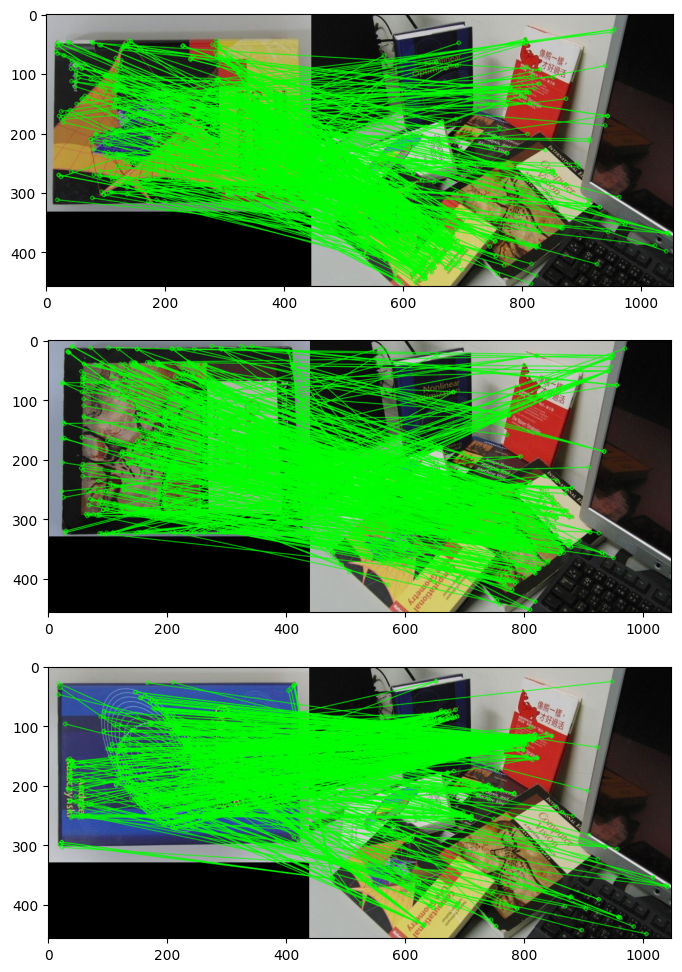

In [102]:
fig, ax = plt.subplots(3, 1, figsize=(10, 12))
thresholds = [283, 200, 301]
matches_idx = []

for i, (book, book_feat, th) in enumerate(zip(books, books_feat, thresholds)):
    matches_idx.append(sift_matching(book_feat.desc, image_feat.desc, th))
    print(len(matches_idx[-1]))
    matches_img = cv2.drawMatchesKnn(
        book, book_feat.keypoints, image, image_feat.keypoints, matches_idx[-1], None,
        flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS,
        matchColor=(0, 255, 0))
    ax[i].imshow(matches_img[..., ::-1])

In [105]:
books_feat[0]

SiftFeature(keypoints=(< cv2.KeyPoint 000001C071B0D3C0>, < cv2.KeyPoint 000001C071B0D5D0>, < cv2.KeyPoint 000001C071B0D600>, < cv2.KeyPoint 000001C071B0D300>, < cv2.KeyPoint 000001C071B0D630>, < cv2.KeyPoint 000001C071B0D660>, < cv2.KeyPoint 000001C071B0D690>, < cv2.KeyPoint 000001C071B0D6C0>, < cv2.KeyPoint 000001C071B0D6F0>, < cv2.KeyPoint 000001C071B0D720>, < cv2.KeyPoint 000001C071B0D7B0>, < cv2.KeyPoint 000001C071B0D7E0>, < cv2.KeyPoint 000001C071B0D840>, < cv2.KeyPoint 000001C071B0D870>, < cv2.KeyPoint 000001C071B0D8A0>, < cv2.KeyPoint 000001C071B0D8D0>, < cv2.KeyPoint 000001C071B0D930>, < cv2.KeyPoint 000001C071B0D960>, < cv2.KeyPoint 000001C071B0D990>, < cv2.KeyPoint 000001C071B0D9C0>, < cv2.KeyPoint 000001C071B0D9F0>, < cv2.KeyPoint 000001C071B0DA20>, < cv2.KeyPoint 000001C071B0DA50>, < cv2.KeyPoint 000001C071B0DA80>, < cv2.KeyPoint 000001C071B0DB10>, < cv2.KeyPoint 000001C071B0DAB0>, < cv2.KeyPoint 000001C071B0DAE0>, < cv2.KeyPoint 000001C071B0DB40>, < cv2.KeyPoint 000001C071

In [106]:
flattened_matches = list(chain.from_iterable(matches_idx[0]))
coords = coords_from_matches(flattened_matches, books_feat[0], image_feat)
matched_book_kp = [books_feat[0].keypoints[m.queryIdx] for m in flattened_matches]
matched_image_kp = [image_feat.keypoints[m.trainIdx] for m in flattened_matches]
len(matched_book_kp)

502

In [107]:
best_agrees = None
max_agrees = -1
best_matches = None
for _ in range(1000):
    rand_coords = random.choices(coords, k=4)
    rand_coords = list(zip(*rand_coords))

    H = solve_homography(*rand_coords)

    match_pts = np.array(list(zip(*coords)))
    book_pts, image_pts = np.concatenate([match_pts, np.ones_like(match_pts)[..., :1]], axis=-1)

    warpped = (H @ book_pts[..., np.newaxis]).reshape((-1, 3))
    warpped /= warpped[:, 2:]

    distance = np.linalg.norm(warpped - image_pts, axis=1)
    agrees = distance < 100
    agrees_count = agrees.sum()
    if agrees_count > max_agrees:
        max_agrees = agrees_count
        best_agrees = agrees
        best_matches = book_pts[agrees], image_pts[agrees]

In [108]:
best_agrees

array([ True, False, False,  True, False,  True,  True,  True, False,
       False, False, False, False, False,  True, False,  True, False,
        True,  True, False,  True, False,  True,  True, False, False,
        True,  True,  True, False, False,  True, False, False,  True,
       False,  True,  True, False,  True,  True, False,  True, False,
        True, False,  True, False, False,  True,  True, False, False,
        True, False, False, False,  True, False, False, False,  True,
       False, False, False,  True, False,  True,  True, False,  True,
        True, False,  True,  True,  True, False, False,  True, False,
       False,  True, False,  True,  True,  True, False,  True, False,
       False, False,  True,  True, False,  True, False,  True, False,
       False,  True,  True, False, False, False, False,  True, False,
        True,  True, False,  True, False,  True, False,  True,  True,
       False,  True, False,  True,  True, False, False, False,  True,
        True, False,

In [109]:
best_matches[0][..., :2]

array([[ 16.19005585,  62.51811218],
       [ 18.81930733, 311.79504395],
       [ 19.70072365,  47.99599838],
       [ 21.05607033, 269.92144775],
       [ 21.05607033, 269.92144775],
       [ 28.82192612, 181.43309021],
       [ 35.96524429, 165.88809204],
       [ 38.11585999,  47.9608078 ],
       [ 40.61625671, 160.95578003],
       [ 42.13820267, 264.09664917],
       [ 43.32037354,  78.51808929],
       [ 48.13285828, 121.09601593],
       [ 50.1132164 ,  85.79457855],
       [ 50.1132164 ,  85.79457855],
       [ 50.20264816,  95.84262085],
       [ 59.47959518, 143.01342773],
       [ 61.37902069, 141.1103363 ],
       [ 70.19486237, 138.92272949],
       [ 74.58323669, 109.47766113],
       [ 74.91454315, 209.83650208],
       [ 75.87684631, 215.25749207],
       [ 77.48400879, 308.49212646],
       [ 79.65213013, 227.02896118],
       [ 83.00953674, 201.06204224],
       [ 88.8786087 , 270.72137451],
       [ 89.35703278,  51.23878098],
       [ 91.64780426,  52.07792282],
 

In [110]:
matches_idx = [[cv2.DMatch(i, i, 0)] for i in range(len(best_matches[0]))]
matched_book_kp = [mkp for (agree, mkp) in zip(best_agrees, matched_book_kp) if agree]
matched_image_kp = [mkp for (agree, mkp) in zip(best_agrees, matched_image_kp) if agree]
len(matched_book_kp)

313

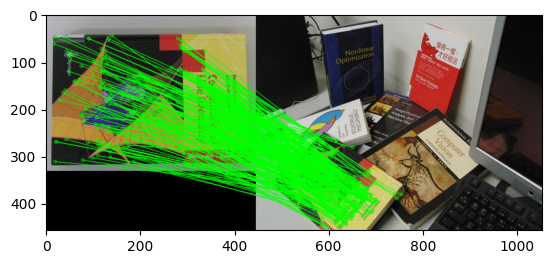

In [111]:
matches_img = cv2.drawMatchesKnn(
    books[0], matched_book_kp, image, matched_image_kp, matches_idx, None,
    flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS,
    matchColor=(0, 255, 0))
plt.imshow(matches_img[..., ::-1])